# Coursera Capstone - Final Project
## Introduction/Business Problem

Coffee Shops are increasingly common accross the world and so the purpose of this analysis is to try and identify Postcodes in Toronto that do not contain any coffee shops, then classify these postcodes into categories based on the other types of venues within the Postcode.

Stakeholders that would be interested in the report are Coffee Shop chains looking to identify new locations to branch out into, or smaller Coffee Shop owners who are looking for places to open a Shop. Essentially, the analysis and report will provide insight into where no such Coffee Shop exists and also information about the environment that sits around the location, with details of whether the other venues in the area would be complimentary and/or suitable for a Shop to open.

In order to answer this question, I will: A) Identify Postcodes which do not currently have any Coffee Shops - this will be my population B) Using this population, I will then extract the venue information for all other venues in the Postcode C) Categorise these into "look - alike" Postcodes, using clustering techniques D) Describe the different types of Postcodes where a new Coffee Shop may wish to consider opening

The report will allow location planners to be able to identify the correct Postcode to open their new shop, based on the desired environments.

## Data

Data
The data I will use will come from three sources:

A) The Toronto Postcodes Wikipedia page. This will provide the details of all of the Postcodes in the Toronto area. B) The geospatial co-ordinates for the Toronto Postcodes. These are provided in a csv which has been extracted from the Geocoder Python Package. C) Foursquare data, which will be used for 2 purposes: 1) To identify which Postcodes do not have any Coffee Shops and 2) To identify the other types of Venue which exist in each of the Postcodes in the no Coffee Shop population.

To use these datasets, I will: A) Scrape the wikipedia page using the pandas read_html functionality B) Join the postcode data from the above, to the geo location data that is present in the csv file C) Use the resultant data set to query Foursquare and pull out the details for all venues in each of the Postcodes D) Identify how many Coffee Shops are in each of the Postcodes, and then limit the population to those which contain none E) Use the remaining Venue data to produce clusters to describe the other types of businesses in the Postcode

## Data Analysis

#### Import required libraries

In [74]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Link to wikipedia and extract postcodes

In [9]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #Assign Wiki page to URL
data = pd.read_html(url, header = 0)[0] # Read HTML table from Wiki Page
data.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [138]:
data.shape

(288, 3)

#### Drop columns other than Postcodes and remove duplicates

In [17]:
data1 = pd.DataFrame(data['Postcode'])
postcodes = data1.drop_duplicates()
postcodes.head()

,Postcode
0,M1A
1,M2A
2,M3A
3,M4A
4,M5A


In [18]:
postcodes.shape

(180, 1)

#### Get Geolocation data for each postcode

In [11]:
links = 'https://cocl.us/Geospatial_data' # Assign variable links to the csv file containing Geolocation data
geo_data = pd.read_csv(links) # Create DataFrame
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
geo_data.shape

(103, 3)

#### Join Postcode data and Geolocation. Where no Geolocation data exists, exclude from analysis as we cannot call Foursquare

In [24]:
geo_data.rename(columns={'Postal Code': 'Postcode'}, inplace=True) # rename column to join on
Toronto_data = pd.merge(postcodes, geo_data, on = 'Postcode')
Toronto_data.head()

,Postcode,Latitude,Longitude
0,M3A,43.753259,-79.329656
1,M4A,43.725882,-79.315572
2,M5A,43.654260,-79.360636
3,M6A,43.718518,-79.464763
4,M7A,43.662301,-79.389494


In [25]:
Toronto_data.shape

(103, 3)

In [26]:
print(Toronto_data.Postcode.nunique()) # Check unique Postcodes - should match shape

103


#### Create Map of Toronto and show Postcodes

In [27]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [31]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng in zip(Toronto_data['Latitude'], Toronto_data['Longitude']):
    label = '{}, {}'.format(lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and then call the API

In [32]:
CLIENT_ID = 'UZWGLR3UJSHQMUE4FW53MMQIVSO1LYIBZKAK50PIBASFK41L' # your Foursquare ID
CLIENT_SECRET = 'PPN40QDVEGXSXCEAVIBBKWK0PVYDFPFNME3U4BO5520BDZPB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UZWGLR3UJSHQMUE4FW53MMQIVSO1LYIBZKAK50PIBASFK41L
CLIENT_SECRET:PPN40QDVEGXSXCEAVIBBKWK0PVYDFPFNME3U4BO5520BDZPB


#### Create function to call API repeatedly and create DataFrame

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
toronto_venues = getNearbyVenues(names=Toronto_data['Postcode'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

M3A
M4A
M5A
M6A
M7A
M9A
M1B
M3B
M4B
M5B
M6B
M9B
M1C
M3C
M4C
M5C
M6C
M9C
M1E
M4E
M5E
M6E
M1G
M4G
M5G
M6G
M1H
M2H
M3H
M4H
M5H
M6H
M1J
M2J
M3J
M4J
M5J
M6J
M1K
M2K
M3K
M4K
M5K
M6K
M1L
M2L
M3L
M4L
M5L
M6L
M9L
M1M
M2M
M3M
M4M
M5M
M6M
M9M
M1N
M2N
M3N
M4N
M5N
M6N
M9N
M1P
M2P
M4P
M5P
M6P
M9P
M1R
M2R
M4R
M5R
M6R
M7R
M9R
M1S
M4S
M5S
M6S
M1T
M4T
M5T
M1V
M4V
M5V
M8V
M9V
M1W
M4W
M5W
M8W
M9W
M1X
M4X
M5X
M8X
M4Y
M7Y
M8Y
M8Z


In [67]:
print(toronto_venues.shape)
toronto_venues.head()

(2259, 7)


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [41]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 280 unique categories.


#### Analyse each Postcode

In [42]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postcode'] = toronto_venues['Postcode'] 

# move Postcode column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint

#### Reduce DataFrame to analyse Coffee Shops

In [82]:
ungrouped_data = toronto_onehot.loc[:,['Postcode', 'Coffee Shop']]
coffee_data = ungrouped_data.groupby('Postcode', as_index = False).sum()
coffee_data.head()

,Postcode,Coffee Shop
0,M1B,0
1,M1C,0
2,M1E,0
3,M1G,2
4,M1H,0
5,M1J,0
6,M1K,1
7,M1L,0
8,M1M,0
9,M1N,0


In [59]:
coffee_data.shape

(100, 2)

In [61]:
coffee_inverted = coffee_data.groupby('Coffee Shop', as_index = False).count() # Counts the number of Postcodes with specific number of Coffee Shops
coffee_inverted

,Coffee Shop,Postcode
0,0,51
1,1,17
2,2,9
3,3,6
4,4,3
5,5,2
6,6,3
7,8,1
8,9,1
9,10,3


#### Visualise the result

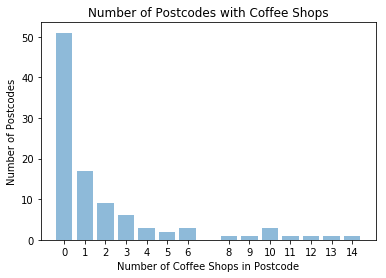

In [76]:
Num_coffee_shops = coffee_inverted['Coffee Shop']
Num_postcodes = coffee_inverted['Postcode']

plt.bar(Num_coffee_shops, Num_postcodes, align='center', alpha=0.5)
plt.xticks(Num_coffee_shops)
plt.ylabel('Number of Postcodes')
plt.xlabel('Number of Coffee Shops in Postcode')
plt.title('Number of Postcodes with Coffee Shops')

plt.show()

#### Create Population for Clustering - Postcodes with zero Coffee Shops

In [109]:
no_coffee0 = coffee_data.loc[coffee_data['Coffee Shop'] == 0] # Select only Postcodes with zero coffee shops
no_coffee1 = pd.merge(no_coffee0, Toronto_data, on = 'Postcode') # Merge to get lat/long data
no_coffee = no_coffee1.loc[:,['Postcode', 'Latitude', 'Longitude']]
no_coffee.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1H,43.773136,-79.239476
4,M1J,43.744734,-79.239476


In [110]:
no_coffee_onehot = pd.merge(no_coffee, toronto_onehot, on = 'Postcode') # Merge with onehot DataFrame
no_coffee_onehot.head()

,Postcode,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,W

In [111]:
no_coffee_onehot.Postcode.nunique() # Check number of unique Postcodes

51

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [112]:
no_coffee_grouped = no_coffee_onehot.groupby('Postcode').mean().reset_index()
no_coffee_grouped.head()

,Postcode,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,W

In [113]:
no_coffee_grouped.shape

(51, 283)

#### Build function and put into DataFrame

In [118]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['Postcode'] = no_coffee_grouped['Postcode']

for ind in np.arange(no_coffee_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(no_coffee_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Print Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
1,M1C,Bar,Construction & Landscaping,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Medical Center,Electronics Store,Spa,Pizza Place,Tech Startup,Breakfast Spot,Intersection,Rental Car Location,Mexican Restaurant,Discount Store
3,M1H,Athletics & Sports,Caribbean Restaurant,Bank,Bakery,Fried Chicken Joint,Thai Restaurant,Lounge,Hakka Restaurant,Cosmetics Shop,Costume Shop
4,M1J,Playground,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore


#### Cluster Postcodes and Visualise

In [133]:
# set number of clusters
kclusters = 3

no_coffee_grouped_clustering = no_coffee_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(no_coffee_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [134]:
# add clustering labels
postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

no_coffee_merged = no_coffee

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
no_coffee_merged = no_coffee_merged.join(postcode_venues_sorted.set_index('Postcode'), on='Postcode')

no_coffee_merged # check the last columns!

,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,43.806686,-79.194353,2,Fast Food Restaurant,Print Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
1,M1C,43.784535,-79.160497,2,Bar,Construction & Landscaping,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,43.763573,-79.188711,2,Medical Center,Electronics Store,Spa,Pizza Place,Tech Startup,Breakfast Spot,Intersection,Rental Car Location,Mexican Restaurant,Discount Store
3,M1H,43.773136,-79.239476,2,Athletics & Sports,Caribbean Restaurant,Bank,Bakery,Fried Chicken Joint,Thai Restaurant,Lounge,Hakka Restaurant,Cosmetics Shop,Costume Shop
4,M1J,43.744734,-79.239476,2,Playground,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
5,M1L,43.711112,-79.284577,2,Bakery,Bus Line,Park,Soccer Field,Bus Station,Metro Station,Intersection,Fast Food Restaurant,Dumpling Restaurant,Drugstore
6,M1M,43.716316,-79.239476,2,Motel,American Restaurant,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,M1N,43.692657,-79.264848,2,College Stadium,Café,Skating Rink,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
8,M1P,43.757410,-79.273304,2,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Pet Store,Comfort Food Restaurant,Comic Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
9,M1R,43.750072,-79.295849,2,Middle Eastern Restaurant,Sandwich Place,Breakfast Spot,Shopping Mall,Bakery,Auto Garage,Yoga Studio,Discount Store,Dog Run,Doner Restaurant


In [127]:
no_coffee_merged.shape

(51, 14)

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(no_coffee_merged['Latitude'], no_coffee_merged['Longitude'], no_coffee_merged['Postcode'], no_coffee_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

Cluster 1: Parks

In [143]:
no_coffee_merged.loc[no_coffee_merged['Cluster Labels'] == 0, no_coffee_merged.columns[[0] + list(range(4, no_coffee_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,M1V,Park,Asian Restaurant,Playground,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
16,M2P,Park,Convenience Store,Bank,Bar,Yoga Studio,Drugstore,Discount Store,Dog Run,Doner Restaurant,Donut Shop
17,M3A,Fast Food Restaurant,Park,Food & Drink Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Department Store
19,M3K,Park,Other Repair Shop,Airport,Yoga Studio,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
27,M4N,Park,Bus Line,Swim School,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
30,M4W,Park,Trail,Playground,Building,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
32,M5P,Trail,Park,Sushi Restaurant,Jewelry Store,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
33,M6B,Park,Pizza Place,Japanese Restaurant,Pub,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
35,M6E,Park,Pharmacy,Women's Store,Fast Food Restaurant,Market,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
41,M8X,Park,Pool,River,Yoga Studio,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


Cluster 2: Baseball Field

In [144]:
no_coffee_merged.loc[no_coffee_merged['Cluster Labels'] == 1, no_coffee_merged.columns[[0] + list(range(4, no_coffee_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,M8Y,Baseball Field,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Dessert Shop
47,M9M,Baseball Field,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Dessert Shop


Cluster 3: Eclectic

In [145]:
no_coffee_merged.loc[no_coffee_merged['Cluster Labels'] == 2, no_coffee_merged.columns[[0] + list(range(4, no_coffee_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Print Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
1,M1C,Bar,Construction & Landscaping,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Medical Center,Electronics Store,Spa,Pizza Place,Tech Startup,Breakfast Spot,Intersection,Rental Car Location,Mexican Restaurant,Discount Store
3,M1H,Athletics & Sports,Caribbean Restaurant,Bank,Bakery,Fried Chicken Joint,Thai Restaurant,Lounge,Hakka Restaurant,Cosmetics Shop,Costume Shop
4,M1J,Playground,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
5,M1L,Bakery,Bus Line,Park,Soccer Field,Bus Station,Metro Station,Intersection,Fast Food Restaurant,Dumpling Restaurant,Drugstore
6,M1M,Motel,American Restaurant,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,M1N,College Stadium,Café,Skating Rink,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
8,M1P,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Pet Store,Comfort Food Restaurant,Comic Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
9,M1R,Middle Eastern Restaurant,Sandwich Place,Breakfast Spot,Shopping Mall,Bakery,Auto Garage,Yoga Studio,Discount Store,Dog Run,Doner Restaurant
